In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 400 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 10.842
Episode: 1 Exploration P: 1.0000 Total reward: -3616.6997787451974 SOC: 1.0000 Cumulative_SOC_deviation: 351.2571 Fuel Consumption: 104.1287

maximum steps, simulation is done ... 
elapsed_time: 9.740
Episode: 2 Exploration P: 1.0000 Total reward: -3609.730032273965 SOC: 1.0000 Cumulative_SOC_deviation: 349.1352 Fuel Consumption: 118.3781

maximum steps, simulation is done ... 
elapsed_time: 9.732
Episode: 3 Exploration P: 1.0000 Total reward: -3633.02597857701 SOC: 1.0000 Cumulative_SOC_deviation: 352.8928 Fuel Consumption: 104.0977

maximum steps, simulation is done ... 
elapsed_time: 9.555
Episode: 4 Exploration P: 1.0000 Total reward: -3621.661117202786 SOC: 0.9999 Cumulative_SOC_deviation: 351.7037 Fuel Consumption: 104.6240


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To cha

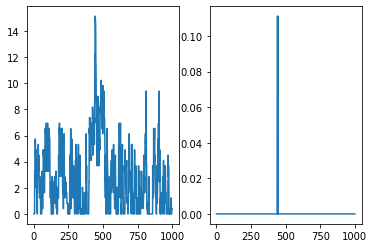

maximum steps, simulation is done ... 
elapsed_time: 61.338
Episode: 11 Exploration P: 0.8879 Total reward: -3552.4127925766356 SOC: 0.9966 Cumulative_SOC_deviation: 346.2152 Fuel Consumption: 90.2611



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 59.049
Episode: 12 Exploration P: 0.8705 Total reward: -3567.5928302771013 SOC: 1.0000 Cumulative_SOC_deviation: 346.2928 Fuel Consumption: 104.6652

maximum steps, simulation is done ... 
elapsed_time: 58.094
Episode: 13 Exploration P: 0.8534 Total reward: -3612.0133536878952 SOC: 1.0000 Cumulative_SOC_deviation: 352.1917 Fuel Consumption: 90.0960

maximum steps, simulation is done ... 
elapsed_time: 57.960
Episode: 14 Exploration P: 0.8367 Total reward: -3560.537107002336 SOC: 1.0000 Cumulative_SOC_deviation: 347.6291 Fuel Consumption: 84.2456

maximum steps, simulation is done ... 
elapsed_time: 57.685
Episode: 15 Exploration P: 0.8203 Total reward: -3572.153937965863 SOC: 1.0000 Cumulative_SOC_deviation: 348.2130 Fuel Consumption: 90.0238

maximum steps, simulation is done ... 
elapsed_time: 58.125
Episode: 16 Exploration P: 0.8043 Total reward: -3453.079447540827 SOC: 1.0000 Cumulative_SOC_deviation: 337.1424 Fuel Consumption: 8

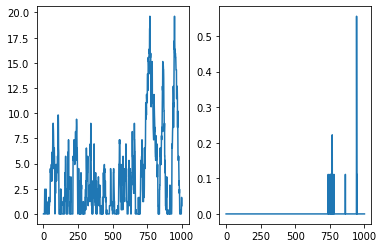

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 58.645
Episode: 21 Exploration P: 0.7286 Total reward: -3288.9710379827034 SOC: 1.0000 Cumulative_SOC_deviation: 319.6213 Fuel Consumption: 92.7581

maximum steps, simulation is done ... 
elapsed_time: 58.809
Episode: 22 Exploration P: 0.7144 Total reward: -3413.377880875971 SOC: 1.0000 Cumulative_SOC_deviation: 333.4405 Fuel Consumption: 78.9731

maximum steps, simulation is done ... 
elapsed_time: 59.426
Episode: 23 Exploration P: 0.7004 Total reward: -3329.1358868595444 SOC: 0.9999 Cumulative_SOC_deviation: 325.1380 Fuel Consumption: 77.7555

maximum steps, simulation is done ... 
elapsed_time: 58.853
Episode: 24 Exploration P: 0.6867 Total reward: -3327.584432985979 SOC: 0.9878 Cumulative_SOC_deviation: 324.7745 Fuel Consumption: 79.8398

maximum steps, simulation is done ... 
elapsed_time: 58.227
Episode: 25 Exploration P: 0.6733 Total reward: -3295.5111539384548 SOC: 0.9999 Cumulative_SOC_deviation: 322.2615 Fuel Consumption: 7

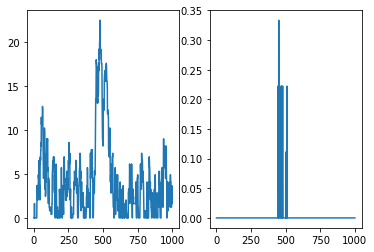

maximum steps, simulation is done ... 
elapsed_time: 57.856
Episode: 31 Exploration P: 0.5982 Total reward: -3343.7133710722387 SOC: 1.0000 Cumulative_SOC_deviation: 327.8216 Fuel Consumption: 65.4976

maximum steps, simulation is done ... 
elapsed_time: 57.389
Episode: 32 Exploration P: 0.5866 Total reward: -3282.829222708396 SOC: 1.0000 Cumulative_SOC_deviation: 321.9932 Fuel Consumption: 62.8974



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 56.748
Episode: 33 Exploration P: 0.5751 Total reward: -3112.1742182138078 SOC: 1.0000 Cumulative_SOC_deviation: 304.4572 Fuel Consumption: 67.6025

maximum steps, simulation is done ... 
elapsed_time: 60.264
Episode: 34 Exploration P: 0.5639 Total reward: -3267.4320729508386 SOC: 1.0000 Cumulative_SOC_deviation: 320.2708 Fuel Consumption: 64.7237

maximum steps, simulation is done ... 
elapsed_time: 80.962
Episode: 35 Exploration P: 0.5530 Total reward: -3107.211788431646 SOC: 0.9634 Cumulative_SOC_deviation: 303.8175 Fuel Consumption: 69.0367

maximum steps, simulation is done ... 
elapsed_time: 71.310
Episode: 36 Exploration P: 0.5422 Total reward: -3201.3253607612323 SOC: 0.9977 Cumulative_SOC_deviation: 313.9130 Fuel Consumption: 62.1958

maximum steps, simulation is done ... 
elapsed_time: 59.349
Episode: 37 Exploration P: 0.5316 Total reward: -3085.0285056456137 SOC: 1.0000 Cumulative_SOC_deviation: 302.1615 Fuel Consumption: 

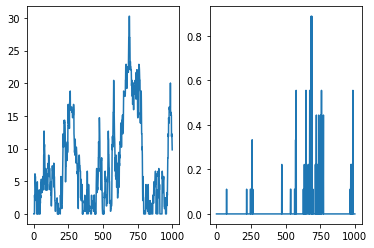

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 74.365
Episode: 41 Exploration P: 0.4915 Total reward: -2663.4211109604953 SOC: 0.9975 Cumulative_SOC_deviation: 259.5932 Fuel Consumption: 67.4890

maximum steps, simulation is done ... 
elapsed_time: 86.470
Episode: 42 Exploration P: 0.4820 Total reward: -2797.120220437669 SOC: 1.0000 Cumulative_SOC_deviation: 273.7762 Fuel Consumption: 59.3583

maximum steps, simulation is done ... 
elapsed_time: 83.048
Episode: 43 Exploration P: 0.4726 Total reward: -2982.0029632762216 SOC: 1.0000 Cumulative_SOC_deviation: 292.4120 Fuel Consumption: 57.8828

maximum steps, simulation is done ... 
elapsed_time: 81.659
Episode: 44 Exploration P: 0.4634 Total reward: -2923.9383399593567 SOC: 1.0000 Cumulative_SOC_deviation: 286.7985 Fuel Consumption: 55.9533

maximum steps, simulation is done ... 
elapsed_time: 87.318
Episode: 45 Exploration P: 0.4544 Total reward: -2954.3005124302395 SOC: 1.0000 Cumulative_SOC_deviation: 289.9864 Fuel Consumption: 

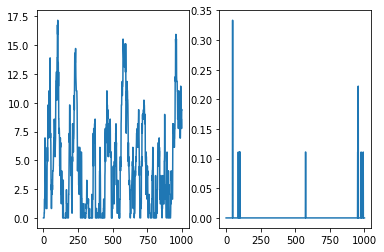

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 87.611
Episode: 51 Exploration P: 0.4041 Total reward: -2705.5320306540425 SOC: 1.0000 Cumulative_SOC_deviation: 265.2757 Fuel Consumption: 52.7753

maximum steps, simulation is done ... 
elapsed_time: 89.882
Episode: 52 Exploration P: 0.3963 Total reward: -2860.200649123741 SOC: 0.9989 Cumulative_SOC_deviation: 280.8653 Fuel Consumption: 51.5475

maximum steps, simulation is done ... 
elapsed_time: 78.645
Episode: 53 Exploration P: 0.3887 Total reward: -1959.7037646487001 SOC: 0.9789 Cumulative_SOC_deviation: 190.3627 Fuel Consumption: 56.0771

maximum steps, simulation is done ... 
elapsed_time: 70.967
Episode: 54 Exploration P: 0.3812 Total reward: -2468.005156732257 SOC: 0.9992 Cumulative_SOC_deviation: 241.7221 Fuel Consumption: 50.7839

maximum steps, simulation is done ... 
elapsed_time: 70.623
Episode: 55 Exploration P: 0.3738 Total reward: -2425.758191646094 SOC: 0.9959 Cumulative_SOC_deviation: 237.5366 Fuel Consumption: 50

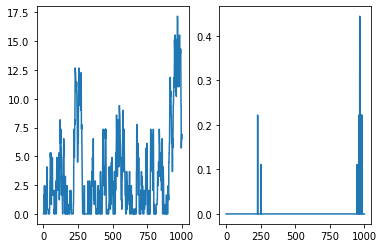

maximum steps, simulation is done ... 
elapsed_time: 60.984
Episode: 61 Exploration P: 0.3326 Total reward: -2149.5287327548162 SOC: 0.9814 Cumulative_SOC_deviation: 210.5968 Fuel Consumption: 43.5612



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 61.834
Episode: 62 Exploration P: 0.3262 Total reward: -1588.9256154688014 SOC: 0.9342 Cumulative_SOC_deviation: 153.7223 Fuel Consumption: 51.7022

maximum steps, simulation is done ... 
elapsed_time: 61.080
Episode: 63 Exploration P: 0.3200 Total reward: -2208.484272707383 SOC: 0.9521 Cumulative_SOC_deviation: 215.2933 Fuel Consumption: 55.5509

maximum steps, simulation is done ... 
elapsed_time: 61.278
Episode: 64 Exploration P: 0.3138 Total reward: -2437.002919708992 SOC: 0.9755 Cumulative_SOC_deviation: 239.2606 Fuel Consumption: 44.3970

maximum steps, simulation is done ... 
elapsed_time: 60.653
Episode: 65 Exploration P: 0.3078 Total reward: -2550.690538079248 SOC: 0.9825 Cumulative_SOC_deviation: 250.8213 Fuel Consumption: 42.4778

maximum steps, simulation is done ... 
elapsed_time: 74.813
Episode: 66 Exploration P: 0.3019 Total reward: -2266.636925441393 SOC: 0.9943 Cumulative_SOC_deviation: 222.7843 Fuel Consumption: 38.

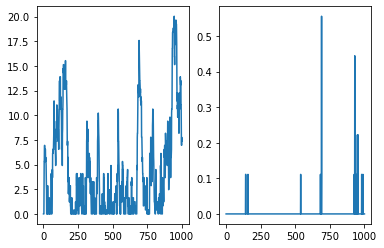

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 82.077
Episode: 71 Exploration P: 0.2741 Total reward: -1672.1837326074888 SOC: 0.9382 Cumulative_SOC_deviation: 163.0810 Fuel Consumption: 41.3738

maximum steps, simulation is done ... 
elapsed_time: 82.618
Episode: 72 Exploration P: 0.2689 Total reward: -2024.615201782396 SOC: 0.9645 Cumulative_SOC_deviation: 198.1281 Fuel Consumption: 43.3342

maximum steps, simulation is done ... 
elapsed_time: 82.018
Episode: 73 Exploration P: 0.2637 Total reward: -1621.0401393243035 SOC: 0.9344 Cumulative_SOC_deviation: 158.0172 Fuel Consumption: 40.8682

battery power is 109250.98321111585(+) but condition is not avail
elapsed_time: 80.563
Episode: 74 Exploration P: 0.2588 Total reward: -2418.531369395425 SOC: 0.8015 Cumulative_SOC_deviation: 138.2887 Fuel Consumption: 37.6591

maximum steps, simulation is done ... 
elapsed_time: 85.403
Episode: 75 Exploration P: 0.2538 Total reward: -1277.4694603194703 SOC: 0.8661 Cumulative_SOC_deviation: 1

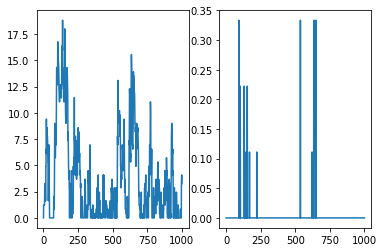

maximum steps, simulation is done ... 
elapsed_time: 57.429
Episode: 81 Exploration P: 0.2262 Total reward: -1561.211230180662 SOC: 0.8928 Cumulative_SOC_deviation: 152.5636 Fuel Consumption: 35.5750



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 58.767
Episode: 82 Exploration P: 0.2220 Total reward: -1110.7631797173394 SOC: 0.6784 Cumulative_SOC_deviation: 106.9678 Fuel Consumption: 41.0849

maximum steps, simulation is done ... 
elapsed_time: 58.838
Episode: 83 Exploration P: 0.2178 Total reward: -1398.3544993772746 SOC: 0.8242 Cumulative_SOC_deviation: 136.4895 Fuel Consumption: 33.4598

maximum steps, simulation is done ... 
elapsed_time: 59.294
Episode: 84 Exploration P: 0.2136 Total reward: -1492.6099640996063 SOC: 0.8373 Cumulative_SOC_deviation: 146.0326 Fuel Consumption: 32.2835

maximum steps, simulation is done ... 
elapsed_time: 59.862
Episode: 85 Exploration P: 0.2096 Total reward: -1211.1714232692764 SOC: 0.8596 Cumulative_SOC_deviation: 118.2293 Fuel Consumption: 28.8785

maximum steps, simulation is done ... 
elapsed_time: 61.239
Episode: 86 Exploration P: 0.2056 Total reward: -1277.5878026179926 SOC: 0.8777 Cumulative_SOC_deviation: 124.5707 Fuel Consumption:

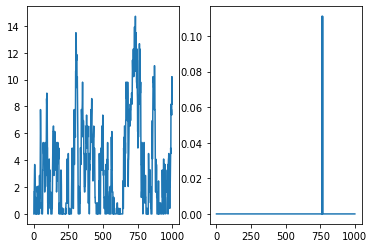

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 60.198
Episode: 91 Exploration P: 0.1870 Total reward: -760.1838264657755 SOC: 0.7223 Cumulative_SOC_deviation: 73.4329 Fuel Consumption: 25.8553

maximum steps, simulation is done ... 
elapsed_time: 58.408
Episode: 92 Exploration P: 0.1835 Total reward: -953.9724471090441 SOC: 0.7742 Cumulative_SOC_deviation: 92.6569 Fuel Consumption: 27.4030



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 59.138
Episode: 93 Exploration P: 0.1801 Total reward: -859.3211840296004 SOC: 0.7533 Cumulative_SOC_deviation: 82.8152 Fuel Consumption: 31.1691

battery power is 120720.96662490541(+) but condition is not avail
elapsed_time: 44.641
Episode: 94 Exploration P: 0.1775 Total reward: -1722.1678663270538 SOC: 0.7167 Cumulative_SOC_deviation: 70.1362 Fuel Consumption: 21.9736

maximum steps, simulation is done ... 
elapsed_time: 58.892
Episode: 95 Exploration P: 0.1742 Total reward: -563.0608027850723 SOC: 0.7142 Cumulative_SOC_deviation: 54.2798 Fuel Consumption: 20.2629

maximum steps, simulation is done ... 
elapsed_time: 59.919
Episode: 96 Exploration P: 0.1710 Total reward: -1101.7058995717932 SOC: 0.7875 Cumulative_SOC_deviation: 107.5933 Fuel Consumption: 25.7728

maximum steps, simulation is done ... 
elapsed_time: 59.463
Episode: 97 Exploration P: 0.1678 Total reward: -377.33804494290325 SOC: 0.6287 Cumulative_SOC_deviation: 34.8

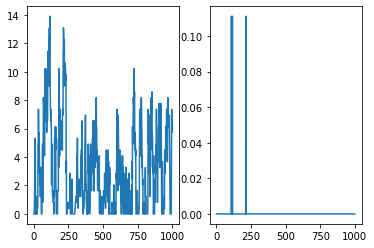

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 60.332
Episode: 101 Exploration P: 0.1556 Total reward: -826.4664057203576 SOC: 0.7334 Cumulative_SOC_deviation: 80.2953 Fuel Consumption: 23.5131

maximum steps, simulation is done ... 
elapsed_time: 59.441
Episode: 102 Exploration P: 0.1527 Total reward: -924.793233127347 SOC: 0.7406 Cumulative_SOC_deviation: 90.0362 Fuel Consumption: 24.4314



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 60.348
Episode: 103 Exploration P: 0.1499 Total reward: -510.19196761236134 SOC: 0.7323 Cumulative_SOC_deviation: 48.5152 Fuel Consumption: 25.0402

maximum steps, simulation is done ... 
elapsed_time: 63.013
Episode: 104 Exploration P: 0.1471 Total reward: -356.42437746432074 SOC: 0.6081 Cumulative_SOC_deviation: 33.3025 Fuel Consumption: 23.3996

maximum steps, simulation is done ... 
elapsed_time: 67.569
Episode: 105 Exploration P: 0.1444 Total reward: -318.1854458647657 SOC: 0.6636 Cumulative_SOC_deviation: 29.6891 Fuel Consumption: 21.2947

maximum steps, simulation is done ... 
elapsed_time: 74.964
Episode: 106 Exploration P: 0.1418 Total reward: -505.1045180346046 SOC: 0.6971 Cumulative_SOC_deviation: 48.5213 Fuel Consumption: 19.8914

maximum steps, simulation is done ... 
elapsed_time: 87.402
Episode: 107 Exploration P: 0.1391 Total reward: -581.1537053328761 SOC: 0.6842 Cumulative_SOC_deviation: 56.0447 Fuel Consumption: 20

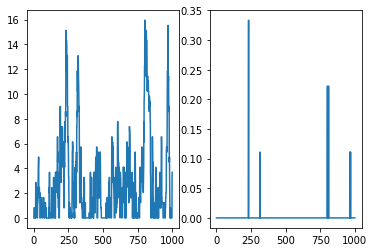

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 59.119
Episode: 111 Exploration P: 0.1292 Total reward: -381.9673909609483 SOC: 0.6624 Cumulative_SOC_deviation: 36.4212 Fuel Consumption: 17.7556

maximum steps, simulation is done ... 
elapsed_time: 59.960
Episode: 112 Exploration P: 0.1268 Total reward: -152.22325716828132 SOC: 0.6041 Cumulative_SOC_deviation: 13.3209 Fuel Consumption: 19.0144

maximum steps, simulation is done ... 
elapsed_time: 87.065
Episode: 113 Exploration P: 0.1245 Total reward: -126.8206144455598 SOC: 0.6026 Cumulative_SOC_deviation: 10.9406 Fuel Consumption: 17.4151

maximum steps, simulation is done ... 
elapsed_time: 94.702
Episode: 114 Exploration P: 0.1223 Total reward: -826.780409368774 SOC: 0.7412 Cumulative_SOC_deviation: 80.3783 Fuel Consumption: 22.9972

maximum steps, simulation is done ... 
elapsed_time: 98.873
Episode: 115 Exploration P: 0.1200 Total reward: -311.52954606112615 SOC: 0.6639 Cumulative_SOC_deviation: 29.2288 Fuel Consumption: 19.

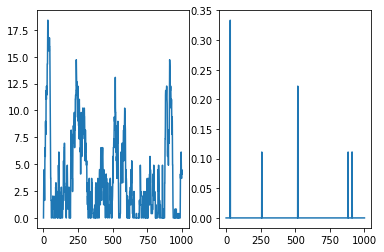

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 72.098
Episode: 121 Exploration P: 0.1076 Total reward: -1334.0179030641054 SOC: 0.2547 Cumulative_SOC_deviation: 130.4706 Fuel Consumption: 29.3119

maximum steps, simulation is done ... 
elapsed_time: 61.779
Episode: 122 Exploration P: 0.1056 Total reward: -595.6168882409761 SOC: 0.5272 Cumulative_SOC_deviation: 57.9770 Fuel Consumption: 15.8467

maximum steps, simulation is done ... 
elapsed_time: 64.596
Episode: 123 Exploration P: 0.1037 Total reward: -149.8255777210524 SOC: 0.5889 Cumulative_SOC_deviation: 13.6259 Fuel Consumption: 13.5664

maximum steps, simulation is done ... 
elapsed_time: 62.132
Episode: 124 Exploration P: 0.1019 Total reward: -278.1466561772926 SOC: 0.5912 Cumulative_SOC_deviation: 25.9617 Fuel Consumption: 18.5294

maximum steps, simulation is done ... 
elapsed_time: 60.350
Episode: 125 Exploration P: 0.1001 Total reward: -445.39311065075077 SOC: 0.5586 Cumulative_SOC_deviation: 42.7287 Fuel Consumption: 1

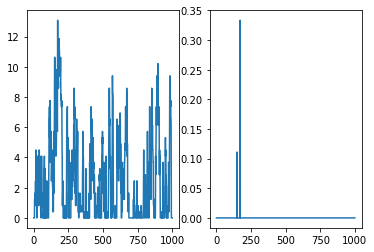

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 56.995
Episode: 131 Exploration P: 0.0906 Total reward: -332.661597072546 SOC: 0.6444 Cumulative_SOC_deviation: 31.8311 Fuel Consumption: 14.3506

maximum steps, simulation is done ... 
elapsed_time: 59.358
Episode: 132 Exploration P: 0.0890 Total reward: -412.92843173900144 SOC: 0.6461 Cumulative_SOC_deviation: 40.0827 Fuel Consumption: 12.1012

maximum steps, simulation is done ... 
elapsed_time: 61.612
Episode: 133 Exploration P: 0.0874 Total reward: -540.5945623953883 SOC: 0.4520 Cumulative_SOC_deviation: 52.6450 Fuel Consumption: 14.1442

maximum steps, simulation is done ... 
elapsed_time: 61.438
Episode: 134 Exploration P: 0.0859 Total reward: -243.26482066389147 SOC: 0.6424 Cumulative_SOC_deviation: 23.1318 Fuel Consumption: 11.9465

maximum steps, simulation is done ... 
elapsed_time: 60.011
Episode: 135 Exploration P: 0.0844 Total reward: -785.5138755115087 SOC: 0.4781 Cumulative_SOC_deviation: 77.0843 Fuel Consumption: 14.

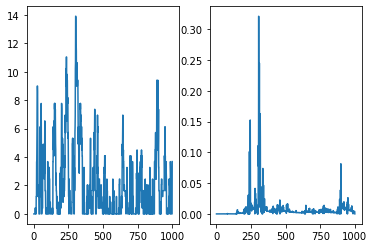

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 58.246
Episode: 141 Exploration P: 0.0760 Total reward: -304.68953973799387 SOC: 0.5709 Cumulative_SOC_deviation: 28.6548 Fuel Consumption: 18.1411

maximum steps, simulation is done ... 
elapsed_time: 58.118
Episode: 142 Exploration P: 0.0747 Total reward: -213.11699611236835 SOC: 0.5400 Cumulative_SOC_deviation: 19.8653 Fuel Consumption: 14.4642

maximum steps, simulation is done ... 
elapsed_time: 58.427
Episode: 143 Exploration P: 0.0734 Total reward: -76.23012431750267 SOC: 0.5999 Cumulative_SOC_deviation: 6.4788 Fuel Consumption: 11.4420

maximum steps, simulation is done ... 
elapsed_time: 57.745
Episode: 144 Exploration P: 0.0721 Total reward: -172.58423778396795 SOC: 0.5905 Cumulative_SOC_deviation: 14.7499 Fuel Consumption: 25.0857

maximum steps, simulation is done ... 
elapsed_time: 58.475
Episode: 145 Exploration P: 0.0709 Total reward: -109.04442452691603 SOC: 0.6038 Cumulative_SOC_deviation: 9.1503 Fuel Consumption: 17

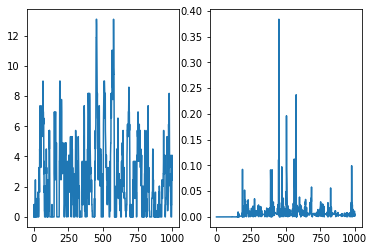

maximum steps, simulation is done ... 
elapsed_time: 59.298
Episode: 151 Exploration P: 0.0640 Total reward: -66.61324964050009 SOC: 0.6174 Cumulative_SOC_deviation: 5.5708 Fuel Consumption: 10.9056



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 61.272
Episode: 152 Exploration P: 0.0629 Total reward: -120.35967603849394 SOC: 0.6029 Cumulative_SOC_deviation: 10.8314 Fuel Consumption: 12.0458

maximum steps, simulation is done ... 
elapsed_time: 57.586
Episode: 153 Exploration P: 0.0619 Total reward: -80.96989398524615 SOC: 0.5808 Cumulative_SOC_deviation: 6.1105 Fuel Consumption: 19.8647

maximum steps, simulation is done ... 
elapsed_time: 58.255
Episode: 154 Exploration P: 0.0609 Total reward: -98.48841122347127 SOC: 0.5914 Cumulative_SOC_deviation: 8.1746 Fuel Consumption: 16.7424

maximum steps, simulation is done ... 
elapsed_time: 58.034
Episode: 155 Exploration P: 0.0599 Total reward: -267.48778690599687 SOC: 0.5813 Cumulative_SOC_deviation: 24.7929 Fuel Consumption: 19.5586

maximum steps, simulation is done ... 
elapsed_time: 57.950
Episode: 156 Exploration P: 0.0589 Total reward: -82.58678820983937 SOC: 0.6010 Cumulative_SOC_deviation: 6.4546 Fuel Consumption: 18.04

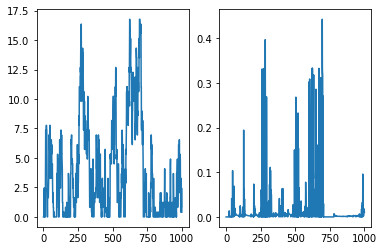

maximum steps, simulation is done ... 
elapsed_time: 57.929
Episode: 161 Exploration P: 0.0542 Total reward: -185.6746372069175 SOC: 0.6125 Cumulative_SOC_deviation: 17.4975 Fuel Consumption: 10.6993



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 144460.81527936744(+) but condition is not avail
elapsed_time: 22.823
Episode: 162 Exploration P: 0.0539 Total reward: -1029.2553775947165 SOC: 0.5854 Cumulative_SOC_deviation: 1.7523 Fuel Consumption: 11.8787

maximum steps, simulation is done ... 
elapsed_time: 58.425
Episode: 163 Exploration P: 0.0530 Total reward: -204.31674728071877 SOC: 0.5806 Cumulative_SOC_deviation: 18.5542 Fuel Consumption: 18.7746

maximum steps, simulation is done ... 
elapsed_time: 57.494
Episode: 164 Exploration P: 0.0521 Total reward: -93.64933119286896 SOC: 0.5997 Cumulative_SOC_deviation: 8.0446 Fuel Consumption: 13.2029

maximum steps, simulation is done ... 
elapsed_time: 58.081
Episode: 165 Exploration P: 0.0513 Total reward: -137.05695563627532 SOC: 0.5558 Cumulative_SOC_deviation: 12.9381 Fuel Consumption: 7.6760

maximum steps, simulation is done ... 
elapsed_time: 58.228
Episode: 166 Exploration P: 0.0505 Total reward: -368.8747147878142 SOC: 0.5632 Cumulative_SOC_deviation: 33.

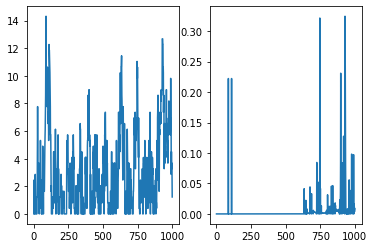

maximum steps, simulation is done ... 
elapsed_time: 57.799
Episode: 171 Exploration P: 0.0466 Total reward: -155.6735813033245 SOC: 0.5785 Cumulative_SOC_deviation: 15.0062 Fuel Consumption: 5.6111



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 58.745
Episode: 172 Exploration P: 0.0459 Total reward: -467.7536487956686 SOC: 0.5236 Cumulative_SOC_deviation: 44.6720 Fuel Consumption: 21.0332

maximum steps, simulation is done ... 
elapsed_time: 58.467
Episode: 173 Exploration P: 0.0452 Total reward: -644.7921114114644 SOC: 0.5367 Cumulative_SOC_deviation: 62.0609 Fuel Consumption: 24.1832

maximum steps, simulation is done ... 
elapsed_time: 58.391
Episode: 174 Exploration P: 0.0445 Total reward: -111.90191007107006 SOC: 0.5831 Cumulative_SOC_deviation: 10.4664 Fuel Consumption: 7.2379

maximum steps, simulation is done ... 
elapsed_time: 58.262
Episode: 175 Exploration P: 0.0438 Total reward: -302.50435021403507 SOC: 0.5616 Cumulative_SOC_deviation: 28.7512 Fuel Consumption: 14.9921

maximum steps, simulation is done ... 
elapsed_time: 58.072
Episode: 176 Exploration P: 0.0431 Total reward: -456.7627982514529 SOC: 0.5522 Cumulative_SOC_deviation: 43.7927 Fuel Consumption: 18.

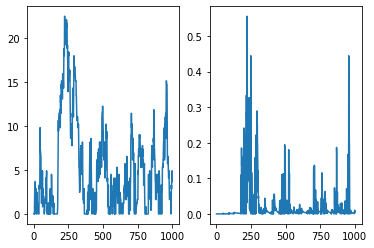

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 57.894
Episode: 181 Exploration P: 0.0404 Total reward: -151.13428021589715 SOC: 0.5827 Cumulative_SOC_deviation: 13.3628 Fuel Consumption: 17.5059

maximum steps, simulation is done ... 
elapsed_time: 57.079
Episode: 182 Exploration P: 0.0398 Total reward: -132.4488501322556 SOC: 0.5897 Cumulative_SOC_deviation: 12.0885 Fuel Consumption: 11.5635

maximum steps, simulation is done ... 
elapsed_time: 58.011
Episode: 183 Exploration P: 0.0392 Total reward: -179.71184359514615 SOC: 0.5635 Cumulative_SOC_deviation: 16.2645 Fuel Consumption: 17.0666

maximum steps, simulation is done ... 
elapsed_time: 56.693
Episode: 184 Exploration P: 0.0386 Total reward: -375.3700241558276 SOC: 0.5456 Cumulative_SOC_deviation: 35.7831 Fuel Consumption: 17.5395

maximum steps, simulation is done ... 
elapsed_time: 57.591
Episode: 185 Exploration P: 0.0380 Total reward: -270.8339394653615 SOC: 0.5539 Cumulative_SOC_deviation: 26.3355 Fuel Consumption: 7.

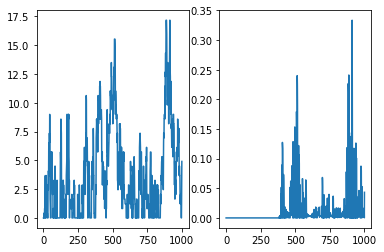

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 106.456
Episode: 191 Exploration P: 0.0349 Total reward: -296.1785460177914 SOC: 0.5414 Cumulative_SOC_deviation: 28.9028 Fuel Consumption: 7.1503

maximum steps, simulation is done ... 
elapsed_time: 102.566
Episode: 192 Exploration P: 0.0344 Total reward: -222.53730373330757 SOC: 0.5790 Cumulative_SOC_deviation: 20.2166 Fuel Consumption: 20.3717

maximum steps, simulation is done ... 
elapsed_time: 103.328
Episode: 193 Exploration P: 0.0339 Total reward: -105.40238407606455 SOC: 0.5762 Cumulative_SOC_deviation: 9.7248 Fuel Consumption: 8.1545

maximum steps, simulation is done ... 
elapsed_time: 103.339
Episode: 194 Exploration P: 0.0334 Total reward: -265.30787604452536 SOC: 0.5618 Cumulative_SOC_deviation: 25.3119 Fuel Consumption: 12.1890

maximum steps, simulation is done ... 
elapsed_time: 98.991
Episode: 195 Exploration P: 0.0330 Total reward: -244.141838535347 SOC: 0.5795 Cumulative_SOC_deviation: 23.3503 Fuel Consumption: 1

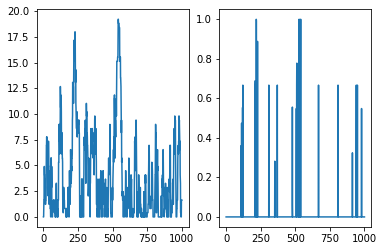

maximum steps, simulation is done ... 
elapsed_time: 79.451
Episode: 201 Exploration P: 0.0304 Total reward: -43.26709152504743 SOC: 0.5973 Cumulative_SOC_deviation: 3.7659 Fuel Consumption: 5.6077



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 63.048
Episode: 202 Exploration P: 0.0300 Total reward: -151.07364520858533 SOC: 0.5848 Cumulative_SOC_deviation: 13.7236 Fuel Consumption: 13.8379

maximum steps, simulation is done ... 
elapsed_time: 61.948
Episode: 203 Exploration P: 0.0296 Total reward: -294.9377570406026 SOC: 0.5843 Cumulative_SOC_deviation: 25.3553 Fuel Consumption: 41.3848

maximum steps, simulation is done ... 
elapsed_time: 69.910
Episode: 204 Exploration P: 0.0292 Total reward: -144.7357995243833 SOC: 0.5875 Cumulative_SOC_deviation: 13.3770 Fuel Consumption: 10.9653

battery power is 132521.49117724196(+) but condition is not avail
elapsed_time: 15.112
Episode: 205 Exploration P: 0.0291 Total reward: -1040.2708181654543 SOC: 0.5861 Cumulative_SOC_deviation: 2.3837 Fuel Consumption: 16.5737

maximum steps, simulation is done ... 
elapsed_time: 67.696
Episode: 206 Exploration P: 0.0287 Total reward: -431.01618376621724 SOC: 0.5695 Cumulative_SOC_deviation: 4

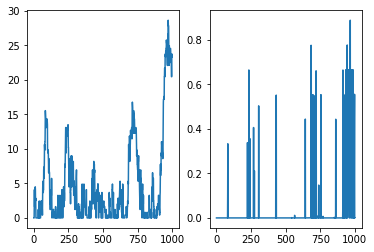

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 61.141
Episode: 211 Exploration P: 0.0269 Total reward: -316.5152289515867 SOC: 0.5648 Cumulative_SOC_deviation: 30.4676 Fuel Consumption: 11.8391

maximum steps, simulation is done ... 
elapsed_time: 63.369
Episode: 212 Exploration P: 0.0266 Total reward: -427.42696648024173 SOC: 0.5286 Cumulative_SOC_deviation: 41.7373 Fuel Consumption: 10.0543

maximum steps, simulation is done ... 
elapsed_time: 59.111
Episode: 213 Exploration P: 0.0263 Total reward: -360.90755954439373 SOC: 0.5689 Cumulative_SOC_deviation: 33.1596 Fuel Consumption: 29.3113

maximum steps, simulation is done ... 
elapsed_time: 58.362
Episode: 214 Exploration P: 0.0259 Total reward: -228.46718008419768 SOC: 0.5727 Cumulative_SOC_deviation: 21.3769 Fuel Consumption: 14.6983

maximum steps, simulation is done ... 
elapsed_time: 58.143
Episode: 215 Exploration P: 0.0256 Total reward: -537.048737949382 SOC: 0.5495 Cumulative_SOC_deviation: 47.3510 Fuel Consumption: 63

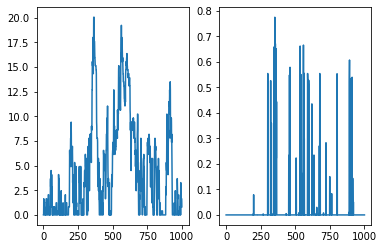

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 82.620
Episode: 221 Exploration P: 0.0239 Total reward: -84.70651363680818 SOC: 0.6163 Cumulative_SOC_deviation: 5.8579 Fuel Consumption: 26.1276

maximum steps, simulation is done ... 
elapsed_time: 83.074
Episode: 222 Exploration P: 0.0236 Total reward: -41.56748788144919 SOC: 0.6023 Cumulative_SOC_deviation: 2.8280 Fuel Consumption: 13.2879

maximum steps, simulation is done ... 
elapsed_time: 81.378
Episode: 223 Exploration P: 0.0233 Total reward: -57.82025422557515 SOC: 0.6022 Cumulative_SOC_deviation: 4.6903 Fuel Consumption: 10.9173

maximum steps, simulation is done ... 
elapsed_time: 74.975
Episode: 224 Exploration P: 0.0230 Total reward: -48.2812240639813 SOC: 0.5904 Cumulative_SOC_deviation: 3.8830 Fuel Consumption: 9.4512

maximum steps, simulation is done ... 
elapsed_time: 77.881
Episode: 225 Exploration P: 0.0228 Total reward: -175.0139005899723 SOC: 0.5916 Cumulative_SOC_deviation: 16.4635 Fuel Consumption: 10.3788

m

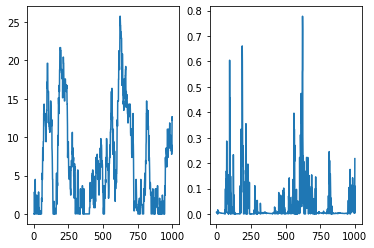

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 67.797
Episode: 231 Exploration P: 0.0213 Total reward: -81.94297240495995 SOC: 0.5795 Cumulative_SOC_deviation: 6.9848 Fuel Consumption: 12.0951

maximum steps, simulation is done ... 
elapsed_time: 79.676
Episode: 232 Exploration P: 0.0211 Total reward: -149.9663174627598 SOC: 0.5912 Cumulative_SOC_deviation: 14.1655 Fuel Consumption: 8.3112

maximum steps, simulation is done ... 
elapsed_time: 76.833
Episode: 233 Exploration P: 0.0209 Total reward: -114.20141463539369 SOC: 0.5910 Cumulative_SOC_deviation: 10.3951 Fuel Consumption: 10.2501

maximum steps, simulation is done ... 
elapsed_time: 58.474
Episode: 234 Exploration P: 0.0207 Total reward: -118.8506059123163 SOC: 0.5992 Cumulative_SOC_deviation: 10.6521 Fuel Consumption: 12.3295

maximum steps, simulation is done ... 
elapsed_time: 58.441
Episode: 235 Exploration P: 0.0205 Total reward: -39.58354336542492 SOC: 0.5947 Cumulative_SOC_deviation: 3.1958 Fuel Consumption: 7.6260

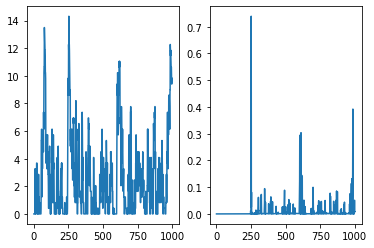

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 58.792
Episode: 241 Exploration P: 0.0193 Total reward: -131.25174412777943 SOC: 0.5878 Cumulative_SOC_deviation: 11.9492 Fuel Consumption: 11.7598

maximum steps, simulation is done ... 
elapsed_time: 62.031
Episode: 242 Exploration P: 0.0191 Total reward: -195.19737400720354 SOC: 0.5863 Cumulative_SOC_deviation: 18.0902 Fuel Consumption: 14.2958

maximum steps, simulation is done ... 
elapsed_time: 63.933
Episode: 243 Exploration P: 0.0189 Total reward: -47.61715872992356 SOC: 0.6040 Cumulative_SOC_deviation: 3.1246 Fuel Consumption: 16.3714

maximum steps, simulation is done ... 
elapsed_time: 63.489
Episode: 244 Exploration P: 0.0187 Total reward: -59.275789506955 SOC: 0.6023 Cumulative_SOC_deviation: 4.9329 Fuel Consumption: 9.9463

maximum steps, simulation is done ... 
elapsed_time: 63.959
Episode: 245 Exploration P: 0.0186 Total reward: -136.37554689866943 SOC: 0.5972 Cumulative_SOC_deviation: 11.5685 Fuel Consumption: 20.690

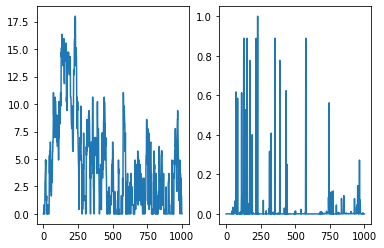

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 58.375
Episode: 251 Exploration P: 0.0176 Total reward: -40.354967627642736 SOC: 0.5978 Cumulative_SOC_deviation: 3.1045 Fuel Consumption: 9.3102

maximum steps, simulation is done ... 
elapsed_time: 58.687
Episode: 252 Exploration P: 0.0174 Total reward: -26.525951143792877 SOC: 0.6030 Cumulative_SOC_deviation: 1.8322 Fuel Consumption: 8.2040

maximum steps, simulation is done ... 
elapsed_time: 59.333
Episode: 253 Exploration P: 0.0173 Total reward: -102.30020069109798 SOC: 0.6054 Cumulative_SOC_deviation: 8.0738 Fuel Consumption: 21.5617

maximum steps, simulation is done ... 
elapsed_time: 58.659
Episode: 254 Exploration P: 0.0172 Total reward: -29.782404396874423 SOC: 0.5965 Cumulative_SOC_deviation: 1.9754 Fuel Consumption: 10.0281

maximum steps, simulation is done ... 
elapsed_time: 58.691
Episode: 255 Exploration P: 0.0170 Total reward: -58.19859959426887 SOC: 0.5994 Cumulative_SOC_deviation: 3.0892 Fuel Consumption: 27.3065

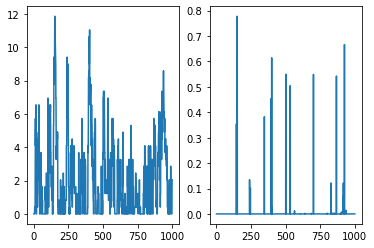

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 77.768
Episode: 261 Exploration P: 0.0162 Total reward: -132.0259026215813 SOC: 0.5832 Cumulative_SOC_deviation: 11.9683 Fuel Consumption: 12.3430

maximum steps, simulation is done ... 
elapsed_time: 77.553
Episode: 262 Exploration P: 0.0161 Total reward: -154.350326053741 SOC: 0.6066 Cumulative_SOC_deviation: 13.7812 Fuel Consumption: 16.5385

maximum steps, simulation is done ... 
elapsed_time: 68.952
Episode: 263 Exploration P: 0.0160 Total reward: -70.29060667840477 SOC: 0.5956 Cumulative_SOC_deviation: 6.1696 Fuel Consumption: 8.5947

battery power is 115224.05321196282(+) but condition is not avail
elapsed_time: 38.301
Episode: 264 Exploration P: 0.0159 Total reward: -1048.2705158366311 SOC: 0.6131 Cumulative_SOC_deviation: 2.8736 Fuel Consumption: 19.7014

maximum steps, simulation is done ... 
elapsed_time: 54.094
Episode: 265 Exploration P: 0.0158 Total reward: -60.33857548465316 SOC: 0.5840 Cumulative_SOC_deviation: 5.2593

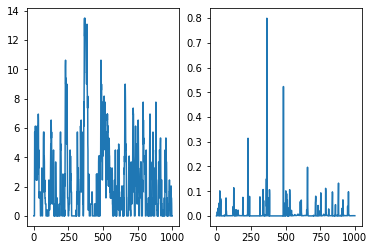

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 53.788
Episode: 271 Exploration P: 0.0151 Total reward: -53.02679514106382 SOC: 0.6019 Cumulative_SOC_deviation: 2.1948 Fuel Consumption: 31.0785

maximum steps, simulation is done ... 
elapsed_time: 53.886
Episode: 272 Exploration P: 0.0150 Total reward: -43.92529100796913 SOC: 0.6008 Cumulative_SOC_deviation: 2.8625 Fuel Consumption: 15.2999

maximum steps, simulation is done ... 
elapsed_time: 54.045
Episode: 273 Exploration P: 0.0149 Total reward: -52.61044187722782 SOC: 0.5869 Cumulative_SOC_deviation: 3.8138 Fuel Consumption: 14.4722

maximum steps, simulation is done ... 
elapsed_time: 53.919
Episode: 274 Exploration P: 0.0148 Total reward: -88.74518361621192 SOC: 0.5916 Cumulative_SOC_deviation: 7.6820 Fuel Consumption: 11.9248

maximum steps, simulation is done ... 
elapsed_time: 53.766
Episode: 275 Exploration P: 0.0147 Total reward: -65.17691295737957 SOC: 0.6076 Cumulative_SOC_deviation: 4.9460 Fuel Consumption: 15.7169



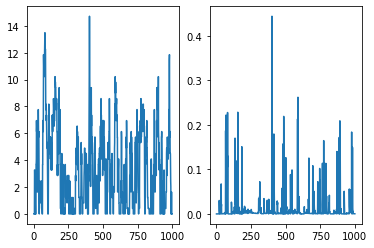

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.191
Episode: 281 Exploration P: 0.0142 Total reward: -49.04599856099402 SOC: 0.6042 Cumulative_SOC_deviation: 3.1094 Fuel Consumption: 17.9523

maximum steps, simulation is done ... 
elapsed_time: 48.939
Episode: 282 Exploration P: 0.0141 Total reward: -89.11707946535572 SOC: 0.5896 Cumulative_SOC_deviation: 7.3823 Fuel Consumption: 15.2939

maximum steps, simulation is done ... 
elapsed_time: 48.550
Episode: 283 Exploration P: 0.0140 Total reward: -70.28786265830468 SOC: 0.5974 Cumulative_SOC_deviation: 5.2894 Fuel Consumption: 17.3943

maximum steps, simulation is done ... 
elapsed_time: 48.956
Episode: 284 Exploration P: 0.0140 Total reward: -39.83147823150743 SOC: 0.5992 Cumulative_SOC_deviation: 3.0204 Fuel Consumption: 9.6278

maximum steps, simulation is done ... 
elapsed_time: 49.428
Episode: 285 Exploration P: 0.0139 Total reward: -73.14329816603038 SOC: 0.5993 Cumulative_SOC_deviation: 6.4538 Fuel Consumption: 8.6057

ma

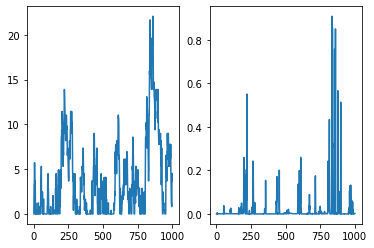

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 48.479
Episode: 291 Exploration P: 0.0134 Total reward: -40.09510754031211 SOC: 0.6101 Cumulative_SOC_deviation: 2.7482 Fuel Consumption: 12.6136

maximum steps, simulation is done ... 
elapsed_time: 48.360
Episode: 292 Exploration P: 0.0134 Total reward: -58.652124810747964 SOC: 0.6047 Cumulative_SOC_deviation: 4.7471 Fuel Consumption: 11.1807

maximum steps, simulation is done ... 
elapsed_time: 48.380
Episode: 293 Exploration P: 0.0133 Total reward: -120.84597588112885 SOC: 0.5917 Cumulative_SOC_deviation: 8.5361 Fuel Consumption: 35.4845

maximum steps, simulation is done ... 
elapsed_time: 48.532
Episode: 294 Exploration P: 0.0132 Total reward: -37.83071727460744 SOC: 0.6041 Cumulative_SOC_deviation: 2.5143 Fuel Consumption: 12.6880

maximum steps, simulation is done ... 
elapsed_time: 48.322
Episode: 295 Exploration P: 0.0132 Total reward: -68.50306828872593 SOC: 0.5962 Cumulative_SOC_deviation: 5.5311 Fuel Consumption: 13.1919

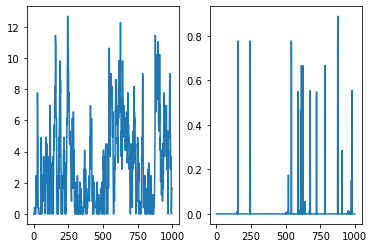

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 48.491
Episode: 301 Exploration P: 0.0128 Total reward: -165.31159238946546 SOC: 0.5822 Cumulative_SOC_deviation: 15.2602 Fuel Consumption: 12.7100

battery power is 109932.6658936937(+) but condition is not avail
elapsed_time: 17.534
Episode: 302 Exploration P: 0.0128 Total reward: -1044.7273855985402 SOC: 0.5723 Cumulative_SOC_deviation: 3.9143 Fuel Consumption: 5.8609

maximum steps, simulation is done ... 
elapsed_time: 48.346
Episode: 303 Exploration P: 0.0127 Total reward: -80.24691526147197 SOC: 0.5942 Cumulative_SOC_deviation: 5.7694 Fuel Consumption: 22.5528

maximum steps, simulation is done ... 
elapsed_time: 48.402
Episode: 304 Exploration P: 0.0127 Total reward: -76.9370699752891 SOC: 0.5895 Cumulative_SOC_deviation: 6.0990 Fuel Consumption: 15.9474

maximum steps, simulation is done ... 
elapsed_time: 48.426
Episode: 305 Exploration P: 0.0126 Total reward: -65.11178641392846 SOC: 0.6046 Cumulative_SOC_deviation: 4.5550 

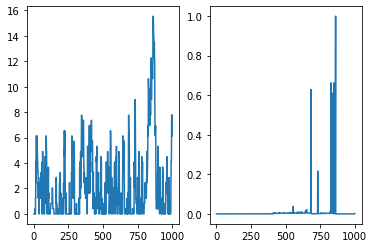

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.239
Episode: 311 Exploration P: 0.0123 Total reward: -298.9721863616835 SOC: 0.5760 Cumulative_SOC_deviation: 28.7813 Fuel Consumption: 11.1592

maximum steps, simulation is done ... 
elapsed_time: 49.411
Episode: 312 Exploration P: 0.0123 Total reward: -68.77190506759193 SOC: 0.6035 Cumulative_SOC_deviation: 5.5516 Fuel Consumption: 13.2564

maximum steps, simulation is done ... 
elapsed_time: 49.366
Episode: 313 Exploration P: 0.0122 Total reward: -40.887081909578306 SOC: 0.5830 Cumulative_SOC_deviation: 3.1675 Fuel Consumption: 9.2126

maximum steps, simulation is done ... 
elapsed_time: 49.441
Episode: 314 Exploration P: 0.0122 Total reward: -79.73375757376472 SOC: 0.5988 Cumulative_SOC_deviation: 6.3356 Fuel Consumption: 16.3778

maximum steps, simulation is done ... 
elapsed_time: 49.301
Episode: 315 Exploration P: 0.0122 Total reward: -68.18134465763166 SOC: 0.5939 Cumulative_SOC_deviation: 5.1946 Fuel Consumption: 16.2352


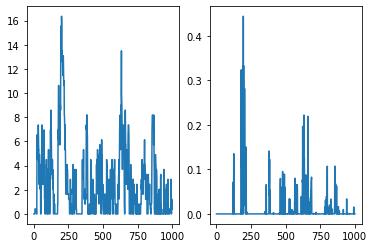

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.279
Episode: 321 Exploration P: 0.0119 Total reward: -132.9433179888594 SOC: 0.5914 Cumulative_SOC_deviation: 9.5376 Fuel Consumption: 37.5674

maximum steps, simulation is done ... 
elapsed_time: 49.251
Episode: 322 Exploration P: 0.0119 Total reward: -74.78221182724147 SOC: 0.5895 Cumulative_SOC_deviation: 6.3766 Fuel Consumption: 11.0160

battery power is 109482.74617086782(+) but condition is not avail
elapsed_time: 38.076
Episode: 323 Exploration P: 0.0118 Total reward: -1071.903086106262 SOC: 0.5966 Cumulative_SOC_deviation: 5.0373 Fuel Consumption: 21.5775

maximum steps, simulation is done ... 
elapsed_time: 49.028
Episode: 324 Exploration P: 0.0118 Total reward: -113.96677475368706 SOC: 0.5865 Cumulative_SOC_deviation: 9.7269 Fuel Consumption: 16.6982

maximum steps, simulation is done ... 
elapsed_time: 48.539
Episode: 325 Exploration P: 0.0118 Total reward: -94.49647610752174 SOC: 0.5943 Cumulative_SOC_deviation: 6.8905

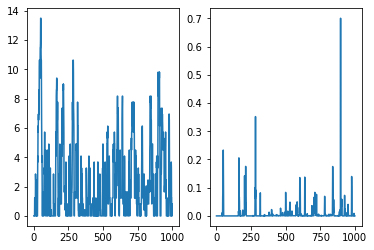

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 49.725
Episode: 331 Exploration P: 0.0116 Total reward: -145.91474202182923 SOC: 0.5809 Cumulative_SOC_deviation: 13.6768 Fuel Consumption: 9.1467



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.535
Episode: 332 Exploration P: 0.0115 Total reward: -145.88661281735492 SOC: 0.5840 Cumulative_SOC_deviation: 12.4061 Fuel Consumption: 21.8251

maximum steps, simulation is done ... 
elapsed_time: 48.868
Episode: 333 Exploration P: 0.0115 Total reward: -165.61786316286768 SOC: 0.5844 Cumulative_SOC_deviation: 15.3769 Fuel Consumption: 11.8486

maximum steps, simulation is done ... 
elapsed_time: 49.554
Episode: 334 Exploration P: 0.0115 Total reward: -166.05689436977417 SOC: 0.5880 Cumulative_SOC_deviation: 15.2082 Fuel Consumption: 13.9750

maximum steps, simulation is done ... 
elapsed_time: 49.681
Episode: 335 Exploration P: 0.0115 Total reward: -173.89623887133752 SOC: 0.5823 Cumulative_SOC_deviation: 16.6492 Fuel Consumption: 7.4045

maximum steps, simulation is done ... 
elapsed_time: 49.280
Episode: 336 Exploration P: 0.0114 Total reward: -174.92404737574435 SOC: 0.5801 Cumulative_SOC_deviation: 16.5712 Fuel Consumption: 

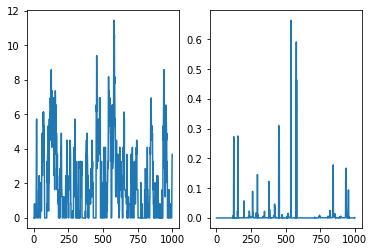

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.374
Episode: 341 Exploration P: 0.0113 Total reward: -105.68647056510436 SOC: 0.5939 Cumulative_SOC_deviation: 9.4544 Fuel Consumption: 11.1428

maximum steps, simulation is done ... 
elapsed_time: 49.041
Episode: 342 Exploration P: 0.0113 Total reward: -120.90804536053759 SOC: 0.5822 Cumulative_SOC_deviation: 10.8182 Fuel Consumption: 12.7261

maximum steps, simulation is done ... 
elapsed_time: 48.599
Episode: 343 Exploration P: 0.0112 Total reward: -141.2953830052095 SOC: 0.5869 Cumulative_SOC_deviation: 13.2434 Fuel Consumption: 8.8611

maximum steps, simulation is done ... 
elapsed_time: 48.644
Episode: 344 Exploration P: 0.0112 Total reward: -133.4430787801778 SOC: 0.5832 Cumulative_SOC_deviation: 7.3098 Fuel Consumption: 60.3450

maximum steps, simulation is done ... 
elapsed_time: 48.654
Episode: 345 Exploration P: 0.0112 Total reward: -208.93735070355152 SOC: 0.5700 Cumulative_SOC_deviation: 19.9544 Fuel Consumption: 9.39

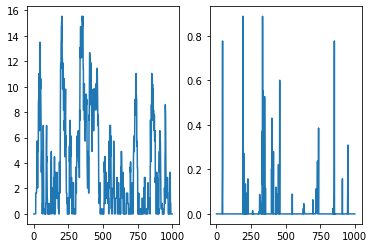

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 48.956
Episode: 351 Exploration P: 0.0111 Total reward: -110.15283622176756 SOC: 0.5890 Cumulative_SOC_deviation: 9.3531 Fuel Consumption: 16.6223

maximum steps, simulation is done ... 
elapsed_time: 48.900
Episode: 352 Exploration P: 0.0110 Total reward: -101.07939950329342 SOC: 0.5831 Cumulative_SOC_deviation: 8.7888 Fuel Consumption: 13.1916

maximum steps, simulation is done ... 
elapsed_time: 49.235
Episode: 353 Exploration P: 0.0110 Total reward: -100.22296766617013 SOC: 0.5886 Cumulative_SOC_deviation: 9.3270 Fuel Consumption: 6.9531

maximum steps, simulation is done ... 
elapsed_time: 49.293
Episode: 354 Exploration P: 0.0110 Total reward: -143.09876714552183 SOC: 0.5818 Cumulative_SOC_deviation: 12.9908 Fuel Consumption: 13.1909

maximum steps, simulation is done ... 
elapsed_time: 49.054
Episode: 355 Exploration P: 0.0110 Total reward: -131.3397002831865 SOC: 0.5893 Cumulative_SOC_deviation: 12.1611 Fuel Consumption: 9.72

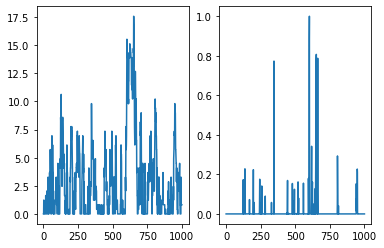

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.058
Episode: 361 Exploration P: 0.0109 Total reward: -111.71916066860037 SOC: 0.5919 Cumulative_SOC_deviation: 9.8502 Fuel Consumption: 13.2175

maximum steps, simulation is done ... 
elapsed_time: 48.578
Episode: 362 Exploration P: 0.0109 Total reward: -86.52103150855592 SOC: 0.5942 Cumulative_SOC_deviation: 7.2928 Fuel Consumption: 13.5927

maximum steps, simulation is done ... 
elapsed_time: 48.655
Episode: 363 Exploration P: 0.0109 Total reward: -117.29779628500859 SOC: 0.5875 Cumulative_SOC_deviation: 10.5741 Fuel Consumption: 11.5569

maximum steps, simulation is done ... 
elapsed_time: 48.577
Episode: 364 Exploration P: 0.0108 Total reward: -201.45886157266094 SOC: 0.5761 Cumulative_SOC_deviation: 19.1844 Fuel Consumption: 9.6150

maximum steps, simulation is done ... 
elapsed_time: 48.687
Episode: 365 Exploration P: 0.0108 Total reward: -233.25475668243493 SOC: 0.5822 Cumulative_SOC_deviation: 22.4984 Fuel Consumption: 8.2

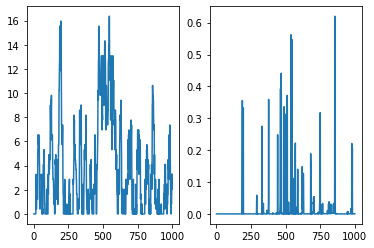

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 48.496
Episode: 371 Exploration P: 0.0107 Total reward: -270.2638632979228 SOC: 0.5784 Cumulative_SOC_deviation: 24.8768 Fuel Consumption: 21.4959

maximum steps, simulation is done ... 
elapsed_time: 48.441
Episode: 372 Exploration P: 0.0107 Total reward: -150.1219802493224 SOC: 0.5869 Cumulative_SOC_deviation: 14.0533 Fuel Consumption: 9.5894

maximum steps, simulation is done ... 
elapsed_time: 48.627
Episode: 373 Exploration P: 0.0107 Total reward: -173.56506057081614 SOC: 0.5682 Cumulative_SOC_deviation: 16.5262 Fuel Consumption: 8.3028

maximum steps, simulation is done ... 
elapsed_time: 48.587
Episode: 374 Exploration P: 0.0107 Total reward: -327.3085768677842 SOC: 0.5622 Cumulative_SOC_deviation: 31.6760 Fuel Consumption: 10.5490

maximum steps, simulation is done ... 
elapsed_time: 48.374
Episode: 375 Exploration P: 0.0107 Total reward: -257.06397666062435 SOC: 0.5953 Cumulative_SOC_deviation: 22.5815 Fuel Consumption: 31.2

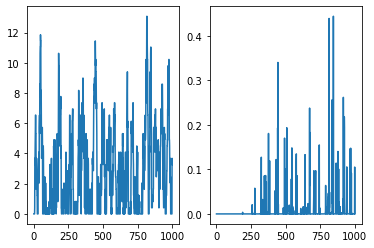

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 48.493
Episode: 381 Exploration P: 0.0106 Total reward: -296.45653133154616 SOC: 0.5707 Cumulative_SOC_deviation: 29.0570 Fuel Consumption: 5.8863

maximum steps, simulation is done ... 
elapsed_time: 48.464
Episode: 382 Exploration P: 0.0106 Total reward: -153.86736606059205 SOC: 0.5945 Cumulative_SOC_deviation: 14.1364 Fuel Consumption: 12.5036

maximum steps, simulation is done ... 
elapsed_time: 48.539
Episode: 383 Exploration P: 0.0106 Total reward: -81.10060682121701 SOC: 0.5898 Cumulative_SOC_deviation: 6.8147 Fuel Consumption: 12.9535

maximum steps, simulation is done ... 
elapsed_time: 48.509
Episode: 384 Exploration P: 0.0106 Total reward: -63.20996336306106 SOC: 0.6087 Cumulative_SOC_deviation: 4.9740 Fuel Consumption: 13.4703

maximum steps, simulation is done ... 
elapsed_time: 48.463
Episode: 385 Exploration P: 0.0105 Total reward: -53.972663753610945 SOC: 0.6008 Cumulative_SOC_deviation: 3.8779 Fuel Consumption: 15.19

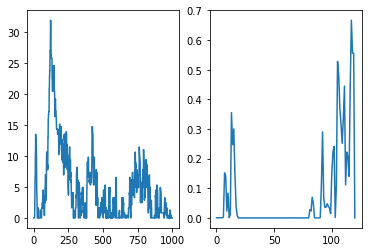

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 48.432
Episode: 391 Exploration P: 0.0105 Total reward: -42.6989093918099 SOC: 0.6040 Cumulative_SOC_deviation: 2.7575 Fuel Consumption: 15.1242

maximum steps, simulation is done ... 
elapsed_time: 48.512
Episode: 392 Exploration P: 0.0105 Total reward: -44.987892953831086 SOC: 0.5989 Cumulative_SOC_deviation: 2.7843 Fuel Consumption: 17.1449

battery power is 105401.15295335249(+) but condition is not avail
elapsed_time: 38.467
Episode: 393 Exploration P: 0.0105 Total reward: -1063.0024761748202 SOC: 0.5957 Cumulative_SOC_deviation: 2.7250 Fuel Consumption: 35.8001

maximum steps, simulation is done ... 
elapsed_time: 48.580
Episode: 394 Exploration P: 0.0105 Total reward: -59.580560273005275 SOC: 0.6030 Cumulative_SOC_deviation: 2.6377 Fuel Consumption: 33.2039

maximum steps, simulation is done ... 
elapsed_time: 48.678
Episode: 395 Exploration P: 0.0105 Total reward: -40.64277515297233 SOC: 0.6019 Cumulative_SOC_deviation: 3.169

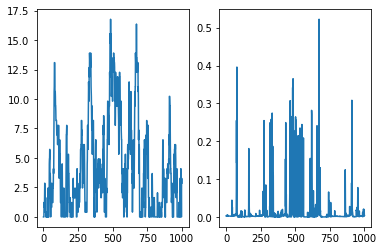

model is saved..


In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
# driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
            
    root = "DDPG_MDP_mass1200"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
            
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_MDP_mass1200.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict